In [ ]:
import os
import sys
import numpy as np
from pathlib import Path
from time import time
import pickle
import logging
from astropy.table import Table
import orpheus
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True)

# Load data

Here we use a mock catalog from the SLICS ensemble

In [ ]:
data = Table.read("/cosma7/data/dp004/dc-port3/Data/SLICS/KiDS450/GalCatalog_LOS1.fits")
pos1 = data["x_arcmin"].data
pos2 = data["y_arcmin"].data
gamma1 = data["shear1"].data
gamma2 = data["shear2"].data
e1 = data["eps_obs1"].data
e2 = data["eps_obs2"].data
zspec = data["z_spectroscopic"].data
zphot = data["z_photometric"].data

In [ ]:
slicsfullreso = orpheus.SpinTracerCatalog(spin=2, pos1=pos1, pos2=pos2, tracer_1=gamma1, tracer_2=gamma2, zbins=None)
print("We have %i galaxies in the mock catalog"%slicsfullreso.ngal)

# Create the multireso catalog

Here we need to choose the gridsizes onto which the mock catalog is mapped.

In [ ]:
dpixs = [0.2*i for i in [1,2,4,8,16,32,64]]
print(dpixs)

Now let us create all the reduced catalogs including the various pixel-mappings between them. Note that here we flatten the outputs, as this is also what is getting passed to the C-library.

In [ ]:
_ = slicsfullreso.genmatched_multiresocats(dpixs,flattened=True)
ngals, resos1, resos2, ngalshifts_1d, ngalshifts_2d, \
pos1s, pos2s, weights, zbins, allfields, \
index_matchers, pixs_galind_bounds, pix_gals, pixmatcher = _
nresos = len(ngals)

# Investigate the multireso catalogs

Let us first see how many galaxies are in each of the reduced catalogs - this level of reduction gives a quadratic reduction for the computation of the Gns and a linear one in the allocation of the Gamma_ns.

In [23]:
print("Number of galaxies:")
print(ngals)
print("Reduction factor:")
print(np.round(slicsfullreso.ngal/ngals,2))

Number of galaxies:
[3070801 2601690 1673997  560118  140625   35344    8836    2209]
Reduction factor:
[   1.      1.18    1.83    5.48   21.84   86.88  347.53 1390.13]


While we always assume the pixels to be quadratic, their size might marginally change given the footprint of the mock. We also set by default the zeroth element of the pixel resolution to zero, indicating that this corresponds to the complete discrete catalog.

In [26]:
print(dpixs)
print(resos1)
print(resos2)

[0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8]
[ 0.          0.19999996  0.39999992  0.79999985  1.59999969  3.19999938
  6.39999877 12.79999754]
[ 0.          0.19999996  0.39999992  0.79999985  1.59999969  3.19999938
  6.39999877 12.79999754]


As an example, let us plot a reduced catalog for some resolution scale. We can see that the points need not to lie in the pixel center, but as we average all locations for sufficiently large pixels the mean location will converge to the pixel center. Note that in this plot, the size of each dots is proportional to the total weight within this specific pixel.

Intrinsic pixel size is 0.80 x 0.80 arcmin


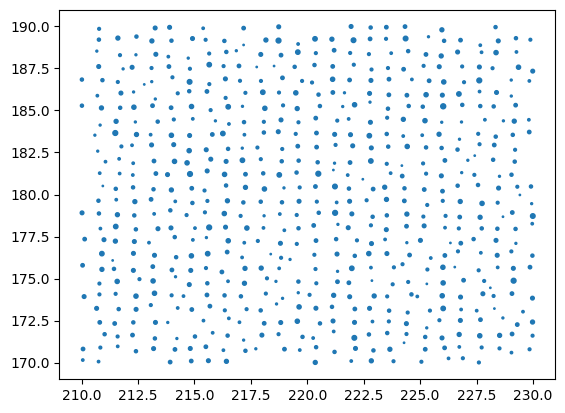

In [117]:
elreso = 3
print("Intrinsic pixel size is %.2f x %.2f arcmin"%(resos1[elreso],resos1[elreso]))
_pos1 = pos1s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]]
_pos2 = pos2s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]]
_ws = weights[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]]
_sel = (_pos1>210)*(_pos1<230)*(_pos2>170)*(_pos2<190)
plt.scatter(_pos1[_sel],
            _pos2[_sel],s=_ws[_sel])
plt.show()

Now let us see how the matcher between two reduced catalogs are working. For this, we choose the reduction scale for the first (`elreso`) and the second (`elreso2`) catalog. We then pick a the index of the galaxy of the lower resolution catalog (`pix_target`) onto which we want to match the indices of the higher resolution catalog.

In the resulting plot we again indicate the total weight of each galaxy by the size of the dot. We also print the cumulative weight of all pixels in the high-resolution catalog - by construction those two numbers are equal to each other.  

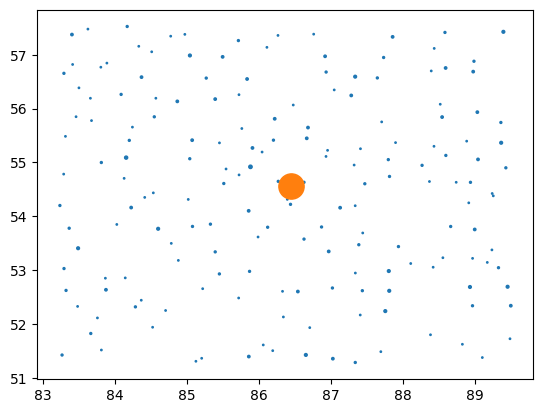

We match 177 galaxies of the high-res catalog to galaxy number 1230 in the low-res catalog
The total weight of the galaxies is 330.00 (high-res) and 330.00 (low res)


In [111]:
pix_target = 1230
elreso = 2
elreso2 = 6

_lower = ngalshifts_2d[elreso*8+elreso2-1]
tmpsel = np.argwhere(pixmatcher[_lower:_lower+ngals[elreso]] == pix_target).flatten()
_ws1 = weights[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][tmpsel]
_ws2 = weights[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][pix_target]
plt.scatter(pos1s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][tmpsel],
            pos2s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][tmpsel],
            s=_ws1)
plt.scatter(pos1s[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][pix_target],
            pos2s[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][pix_target],
            s=weights[ngalshifts_1d[elreso2]:ngalshifts_1d[elreso2+1]][pix_target])    
plt.show()

print("We match %i galaxies of the high-res catalog to galaxy number %i in the low-res catalog"%(len(tmpsel),pix_target))
print("The total weight of the galaxies is %.2f (high-res) and %.2f (low res)"%(np.sum(_ws1),np.sum(_ws2)))

This is basically the same function as before, but we plot a list of pixels, where for each pixel we loop over all resolutions up to the base resolution (on which the spatial hash is defined). Each of those pixels corresponds to a thread that is executed in parallel.

We match 1419 galaxies of the high-res catalog (resolution 0) to galaxy number 1230 in the low-res catalog
The total weight of the galaxies is 1419.00 (high-res) and 1419.00 (base res)
We match 1219 galaxies of the high-res catalog (resolution 1) to galaxy number 1230 in the low-res catalog
The total weight of the galaxies is 1419.00 (high-res) and 1419.00 (base res)
We match 773 galaxies of the high-res catalog (resolution 2) to galaxy number 1230 in the low-res catalog
The total weight of the galaxies is 1419.00 (high-res) and 1419.00 (base res)
We match 254 galaxies of the high-res catalog (resolution 3) to galaxy number 1230 in the low-res catalog
The total weight of the galaxies is 1419.00 (high-res) and 1419.00 (base res)
We match 64 galaxies of the high-res catalog (resolution 4) to galaxy number 1230 in the low-res catalog
The total weight of the galaxies is 1419.00 (high-res) and 1419.00 (base res)
We match 16 galaxies of the high-res catalog (resolution 5) to galaxy number 12

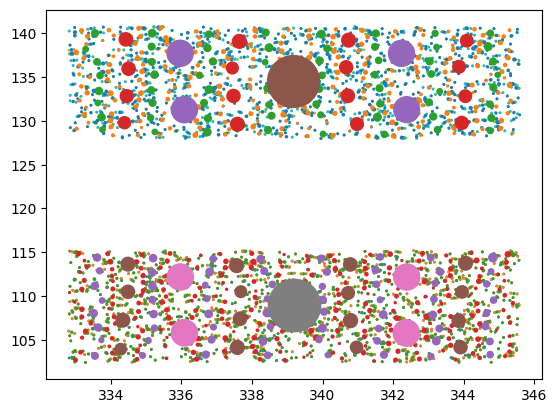

In [115]:
pix_targets = [1230,1232]
for pix_target in pix_targets:
    _wbase = weights[ngalshifts_1d[-2]:ngalshifts_1d[-1]][pix_target]
    for elreso in range(nresos-1):
        _globlower = ngalshifts_2d[elreso*8+(nresos-1)-1]
        tmpsel = np.argwhere(pixmatcher[_globlower:_globlower+ngals[elreso]] == pix_target).flatten()
        _ws = weights[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][tmpsel]
        #print(elreso,len(tmpsel),_lower,np.sum(_ws))
        plt.scatter(pos1s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][tmpsel],
                    pos2s[ngalshifts_1d[elreso]:ngalshifts_1d[elreso+1]][tmpsel],
                    s=_ws)
        print("We match %i galaxies of the high-res catalog (resolution %i) to galaxy number %i in the low-res catalog"%(
            len(tmpsel), elreso, pix_target))
        print("The total weight of the galaxies is %.2f (high-res) and %.2f (base res)"%(np.sum(_ws),_wbase))
    plt.scatter(pos1s[ngalshifts_1d[-2]:ngalshifts_1d[-1]][pix_target],
                pos2s[ngalshifts_1d[-2]:ngalshifts_1d[-1]][pix_target],
                s=_wbase)    
plt.show()

In [118]:
len(pixmatcher)

48217603

In [122]:
len(pixs_galind_bounds)/nresos

1011703.5

In [ ]:
len(pixs_galind_bounds)

In [ ]:
len(pos1)

In [ ]:
1